In [1]:
import pandas as pd
from java_migration.eval.smol_log_parser import parse_log
from pathlib import Path
import numpy as np
from java_migration.eval.utils import recover_safe_repo_name
import yaml
import pandas as pd
import seaborn as sns
from java_migration.utils import REPO_ROOT
import os
from collections.abc import MutableMapping
from java_migration.eval.maven_build_verifier import MavenBuildVerifier
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from java_migration.analysis.utils import get_maven_logs, MavenStatus, visualize_agent_trace, flatten, get_experiment_data

In [2]:
experiment_path = Path(
    # "/Users/mayvic/Documents/git/java-migration-paper/data/experiments/2025-03-09/22-19-56-hopeful-wescoff"
    # "/Users/mayvic/Documents/git/java-migration-paper/data/experiments/2025-03-11/13-55-09-condescending-galileo"
    #"/Users/mayvic/Documents/git/java-migration-paper/data/experiments/2025-03-11/14-14-38-awesome-pasteur"
    "/Users/mayvic/Documents/git/java-migration-paper/data/experiments/2025-03-11/15-14-25-loving-newton"
)
exp_data = get_experiment_data(experiment_path)

In [7]:
def get_experiment_features(exp_data):
    exp_feats = []
    for repo_name, repo_data in exp_data.items():
        cur_feats = {"repo_name": repo_name}
        if "build_result" in repo_data and repo_data["build_result"] is not None:
            cur_feats.update(flatten(repo_data["build_result"]))
        exp_feats.append(cur_feats)
        if "agent_log" in repo_data:
            cur_feats["run_duration"] = np.sum([y.meta.duration for y in repo_data["agent_log"].steps])
            cur_feats["input_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["output_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["num_steps"] = len(repo_data["agent_log"].steps)
            if len(repo_data["agent_log"].steps) > 1:
                if repo_data["agent_log"].steps[-2].execution_logs:                    
                    cur_feats["vertex_fail"] = "RateLimitError" in repo_data["agent_log"].steps[-2].execution_logs
                else:
                    cur_feats["vertex_fail"] = False
            else:
                cur_feats["vertex_fail"] = False
        if "repo_feats" in repo_data:
            cur_feats.update(repo_data["repo_feats"])

    return exp_feats


exp_features = get_experiment_features(exp_data)
df = pd.DataFrame(exp_features)
df

TypeError: argument of type 'NoneType' is not iterable

In [8]:
#df.build_result_build_success.mean()
df.vertex_fail

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
Name: vertex_fail, dtype: bool

In [7]:
df[(df.build_result_test_success == False) | (df.build_result_build_success == False)].repo_name.tolist()

['EalenXie/spring-microservice-ddd',
 'opengoofy/hippo4j',
 'EnterpriseQualityCoding/FizzBuzzEnterpriseEdition',
 'perwendel/spark',
 'anjia0532/unidbg-boot-server']

In [8]:
maven_logs = {repo_name: get_maven_logs(exp_data[repo_name]) for repo_name in exp_data}

In [9]:
repo_names = df.repo_name.tolist()

maven_logs[repo_names[1]]

[{'step': 4, 'status': <MavenStatus.GOAL_ERROR: 7>},
 {'step': 5, 'status': <MavenStatus.GOAL_ERROR: 7>},
 {'step': 9, 'status': <MavenStatus.INVALID_POM: 9>},
 {'step': 17, 'status': <MavenStatus.INVALID_POM: 9>},
 {'step': 20, 'status': <MavenStatus.INVALID_POM: 9>},
 {'step': 22, 'status': <MavenStatus.INVALID_POM: 9>},
 {'step': 24, 'status': <MavenStatus.INVALID_POM: 9>}]

In [10]:
# maven_statuses_by_repo = {repo_name: set([step["status"] for step in maven_logs[repo_name]]) for repo_name in maven_logs}
# maven_statuses_by_repo
{
    status: len(
        [repo_name for repo_name in maven_logs if any(status == step["status"] for step in maven_logs[repo_name])]
    )
    for status in MavenStatus
}

{<MavenStatus.NO_MAVEN: 0>: 0,
 <MavenStatus.COMPILE_ERROR: 1>: 4,
 <MavenStatus.TESTS_STARTED: 2>: 7,
 <MavenStatus.SUCCESS: 3>: 7,
 <MavenStatus.DEPENDENCY_ERROR: 4>: 0,
 <MavenStatus.UNKNOWN_ERROR: 5>: 0,
 <MavenStatus.UNKNOWN: 6>: 0,
 <MavenStatus.GOAL_ERROR: 7>: 6,
 <MavenStatus.PLUGIN_RESOLVE_ERROR: 8>: 0,
 <MavenStatus.INVALID_POM: 9>: 8,
 <MavenStatus.SKIPPED_TESTS: 10>: 1}

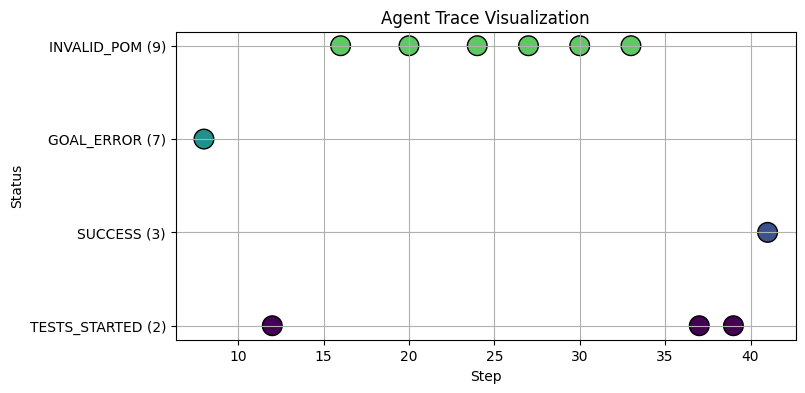

In [11]:
# print(exp_data[repo_names[12]]["agent_log"].steps[15].execution_logs)
visualize_agent_trace(maven_logs["nydiarra/springboot-jwt"])
# print(repo_names[12])

In [12]:
# print(exp_data[repo_names[1]]["agent_log"].steps[48].execution_logs)

In [13]:
df.input_tokens.median()
# 974581.5 anthropic
# 31769216.0 old

# 7414753.5 / 31769216

np.float64(9238719.0)

In [14]:
df.run_duration.median()
# 42.01 anthropic
# 160.52 old

np.float64(90.10000000000001)

In [15]:
df.num_steps.median()
# 13.0 anthropic
# 37.0 old

np.float64(26.0)